In [1]:
import os
os.chdir(os.path.join(os.path.sep, 'home', 'tkokkeng', 'Documents', 'KE5105', 'ETL'))
os.getcwd()

'/home/tkokkeng/Documents/KE5105/ETL'

In [2]:
import sys
if os.path.join(os.getcwd(), 'source') not in sys.path:
    sys.path.append(os.path.join(os.getcwd(), 'source'))
sys.path

['/home/tkokkeng/Documents/KE5105/ETL',
 '/home/tkokkeng/python/python367/tsfvenv/lib',
 '/home/tkokkeng/Documents/KE5105/ETL/source',
 '/home/tkokkeng/Documents/KE5105/ETL/source/results',
 '',
 '/home/tkokkeng/python/python367/tsfvenv/lib/python3.6/site-packages',
 '/home/tkokkeng/python/python367/tsfvenv/lib/python36.zip',
 '/home/tkokkeng/python/python367/tsfvenv/lib/python3.6',
 '/home/tkokkeng/python/python367/tsfvenv/lib/python3.6/lib-dynload',
 '/usr/lib/python3.6',
 '/home/tkokkeng/.local/lib/python3.6/site-packages',
 '/usr/local/lib/python3.6/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/home/tkokkeng/python/python367/tsfvenv/lib/python3.6/site-packages/IPython/extensions',
 '/home/tkokkeng/.ipython']

In [24]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use(os.path.join('mpl_configdir', 'stylelib', 'presentation1.mplstyle'))

import numpy as np
import datetime
import myUtilities as mu
import pickle
import pandas as pd

from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn import svm
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

from keras.models import Sequential, load_model
from keras import layers
from keras.regularizers import l1,l2, l1_l2
from keras.optimizers import RMSprop, Adam, SGD
from keras.callbacks import ModelCheckpoint, TensorBoard, Callback
import keras.backend as K

In [4]:
mrb_train = mu.load_data_by_bldg(['MRB'], 'imputed_train')

In [5]:
mrb_train[0][1].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 31617 entries, 2015-06-12 07:30:00 to 2017-03-31 23:30:00
Data columns (total 10 columns):
PWMMRIC1                     29851 non-null float64
PWMMRIC2                     29851 non-null float64
BTUMochtarRiady              29448 non-null float64
PWMMRIC1_30min_avg           29818 non-null float64
PWMMRIC2_30min_avg           29818 non-null float64
BTUMochtarRiady_30min_avg    29416 non-null float64
PWM_sumadd                   29818 non-null float64
PWM_30min_avg                29861 non-null float64
BTU_sumadd                   29416 non-null float64
BTU_30min_avg                29469 non-null float64
dtypes: float64(10)
memory usage: 2.7 MB


In [6]:
mrb_train_df = mrb_train[0][1]
mrb_train_split_df = mrb_train_df[:20000]
mrb_val_split_df = mrb_train_df[20000:]

# Create a transformation pipleline to prepare the training dataset for RNN.
attrbs = ['PWM_30min_avg', 'BTU_30min_avg']
my_pipeline = Pipeline([
    ('selector', mu.DataFrameSelector(attrbs)),
    ('minmax_scaler', MinMaxScaler()),
    ('na_transform', mu.Nan_to_Num_Transformer())
])
mrb_train_data = my_pipeline.fit_transform(mrb_train_split_df)
mrb_val_data = my_pipeline.transform(mrb_val_split_df)

In [7]:
lookback = 240  # 5 days; each day has 48 observations
step = 1  # sampling rate used for the lookback period
delay = 0  # 1 step ahead prediction
batch_size = 128

In [8]:
gen_train = mu.DataGenerator(mrb_train_data,
                             lookback=lookback, delay=delay, min_index=0, max_index=len(mrb_train_data) - 1,
                             batch_size=batch_size, step=step)
gen_val = mu.DataGenerator(mrb_val_data,
                           lookback=lookback, delay=delay, min_index=0, max_index=len(mrb_val_data) - 1,
                           batch_size=batch_size, step=step)

In [9]:
X_list, y_list = [], []
for i in range(gen_train.__len__()):
    samples, targets = gen_train.__getitem__(i)
    X_list.append(samples)
    y_list.append(targets)
X_train = np.concatenate(X_list)
y_train = np.concatenate(y_list)
X_train = X_train.reshape((-1, lookback * 2))
mask = np.apply_along_axis(all, axis=1, arr=(X_train > mu.MASK_VALUE))
X_train = X_train[mask,]
y_train = y_train[mask,]
X_list, y_list = [], []
for i in range(gen_val.__len__()):
    samples, targets = gen_val.__getitem__(i)
    X_list.append(samples)
    y_list.append(targets)
X_val = np.concatenate(X_list)
y_val = np.concatenate(y_list)
X_val = X_val.reshape((-1, lookback * 2))
mask = np.apply_along_axis(any, axis=1, arr=(X_val == mu.MASK_VALUE))
X_val = X_val[np.logical_not(mask),]
y_val = y_val[np.logical_not(mask),]

## SVR Best Model

In [10]:
best_model = svm.SVR(kernel='rbf', gamma=0.001, C=100, cache_size=1000, max_iter=-1)
best_model.fit(X_train, y_train)
mrb_train_preds = best_model.predict(X_train)
mrb_val_preds = best_model.predict(X_val)
mae_train, mae_val = mean_absolute_error(mrb_train_preds, y_train), mean_absolute_error(mrb_val_preds, y_val)
print('Training Loss = {:.4f}\nValidation Loss = {:.4f}\nTraining MAE = {:.4f}\nValidation MAE = {:.4f}'.format(
    mae_train, mae_val,
    mae_train * (mrb_train_split_df['PWM_30min_avg'].max() - mrb_train_split_df['PWM_30min_avg'].min()),
    mae_val * (mrb_train_split_df['PWM_30min_avg'].max() - mrb_train_split_df['PWM_30min_avg'].min())))

Training Loss = 0.0318
Validation Loss = 0.0318
Training MAE = 4.3373
Validation MAE = 4.3375


In [11]:
mrb_train_preds = mrb_train_preds.reshape((-1, 1))
mrb_train_preds1 = np.concatenate([mrb_train_preds, np.zeros((mrb_train_preds.shape[0], 1))], axis=1)
mrb_train_preds1 = my_pipeline.inverse_transform(mrb_train_preds1)
mrb_train_preds_withnan = np.full((mrb_train_data.shape[0] - delay, 1), np.NaN)
j = 0
for i in range(lookback, len(mrb_train_data)):
    if (mrb_train_data[i, 0] > mu.MASK_VALUE) and (np.all(mrb_train_data[i - lookback:i, 0] > mu.MASK_VALUE)) and (np.all(mrb_train_data[i - lookback:i, 1] > mu.MASK_VALUE)):
        mrb_train_preds_withnan[i] = mrb_train_preds1[j, 0]
        j += 1
mrb_val_preds = mrb_val_preds.reshape((-1, 1))
mrb_val_preds1 = np.concatenate([mrb_val_preds, np.zeros((mrb_val_preds.shape[0], 1))], axis=1)
mrb_val_preds1 = my_pipeline.inverse_transform(mrb_val_preds1)
mrb_val_preds_withnan = np.full((mrb_val_data.shape[0] - delay, 1), np.NaN)
j = 0
for i in range(lookback, len(mrb_val_data)):
    if (mrb_val_data[i, 0] > mu.MASK_VALUE) and (np.all(mrb_val_data[i - lookback:i, 0] > mu.MASK_VALUE)) and (np.all(mrb_val_data[i - lookback:i, 1] > mu.MASK_VALUE)):
        mrb_val_preds_withnan[i] = mrb_val_preds1[j, 0]
        j += 1

## Load 4x128 GRU 2x32 Dense Best Model With Regularisation

In [12]:
# Custom mape metric. Skips all zero values of y-true in computing the mape metric.
import tensorflow as tf
def mape_skip_zeros(y_true, y_pred):
    y_true1 = tf.boolean_mask(y_true, y_true > 0)
    y_pred1 = tf.boolean_mask(y_pred, y_true > 0)
    diff = K.abs((y_true1 - y_pred1) / y_true1)
    return 100. * K.mean(diff, axis=-1)

In [13]:
model128 = load_model(os.path.join('final results', 'models', 'MRB-wgtreg2-4x128gru-2x32dense.best-epch387.h5'),
                      custom_objects={'mape_skip_zeros': mape_skip_zeros})
model128.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnngru_1 (CuDNNGRU)       (None, None, 128)         50688     
_________________________________________________________________
cu_dnngru_2 (CuDNNGRU)       (None, None, 128)         99072     
_________________________________________________________________
cu_dnngru_3 (CuDNNGRU)       (None, None, 128)         99072     
_________________________________________________________________
cu_dnngru_4 (CuDNNGRU)       (None, 128)               99072     
_________________________________________________________________
dense_1 (Dense)              (None, 32)                4128      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total para

In [14]:
# gen_pred = mu.DataGenerator(mrb_train_data,
#                             lookback=lookback, delay=delay, min_index=0, max_index=len(mrb_train_data) - 1,
#                             batch_size=batch_size, step=step)
# mrb_train_preds128 = model128.predict_generator(gen_pred, workers=3, use_multiprocessing=False)
# mrb_train_preds128 = np.concatenate([mrb_train_preds128, np.zeros((mrb_train_preds128.shape[0], 1))], axis=1)
# mrb_train_preds128 = my_pipeline.inverse_transform(mrb_train_preds128)
# mrb_train_preds128_withnan = np.full((mrb_train_data.shape[0] - delay, 1), np.NaN)
# j = 0
# for i in range(lookback, len(mrb_train_data)):
#     if (mrb_train_data[i, 0] > mu.MASK_VALUE) and (np.any(mrb_train_data[i - lookback:i, 0] > mu.MASK_VALUE)):
#         mrb_train_preds128_withnan[i] = mrb_train_preds128[j, 0]
#         j += 1

In [15]:
gen_val_pred = mu.DataGenerator(mrb_val_data,
                                lookback=lookback, delay=delay, min_index=0, max_index=len(mrb_val_data) - 1,
                                batch_size=batch_size, step=step)
mrb_val_preds128 = model128.predict_generator(gen_val_pred, workers=3, use_multiprocessing=False)
mrb_val_preds128 = np.concatenate([mrb_val_preds128, np.zeros((mrb_val_preds128.shape[0], 1))], axis=1)
mrb_val_preds128 = my_pipeline.inverse_transform(mrb_val_preds128)
mrb_val_preds128_withnan = np.full((mrb_val_data.shape[0] - delay, 1), np.NaN)
j = 0
for i in range(lookback, len(mrb_val_data)):
    if (mrb_val_data[i, 0] > mu.MASK_VALUE) and (np.any(mrb_val_data[i - lookback:i, 0] > mu.MASK_VALUE)):
        mrb_val_preds128_withnan[i] = mrb_val_preds128[j, 0]
        j += 1

## Load 4x64 GRU 1x32 Dense Best Model With Regularisation

In [16]:
model64 = load_model(os.path.join('final results', 'colab models', 'MRB-1wgtreg-4x64gru-1x32dense.best-epch640.h5'),
                      custom_objects={'mape_skip_zeros': mape_skip_zeros})
model64.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnngru_1 (CuDNNGRU)       (None, None, 64)          13056     
_________________________________________________________________
cu_dnngru_2 (CuDNNGRU)       (None, None, 64)          24960     
_________________________________________________________________
cu_dnngru_3 (CuDNNGRU)       (None, None, 64)          24960     
_________________________________________________________________
cu_dnngru_4 (CuDNNGRU)       (None, 64)                24960     
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 90,049
Trainable params: 90,049
Non-trainable params: 0
_________________________________________________________________


In [17]:
gen_val_pred = mu.DataGenerator(mrb_val_data,
                                lookback=lookback, delay=delay, min_index=0, max_index=len(mrb_val_data) - 1,
                                batch_size=batch_size, step=step)
mrb_val_preds64 = model64.predict_generator(gen_val_pred, workers=3, use_multiprocessing=False)
mrb_val_preds64 = np.concatenate([mrb_val_preds64, np.zeros((mrb_val_preds64.shape[0], 1))], axis=1)
mrb_val_preds64 = my_pipeline.inverse_transform(mrb_val_preds64)
mrb_val_preds64_withnan = np.full((mrb_val_data.shape[0] - delay, 1), np.NaN)
j = 0
for i in range(lookback, len(mrb_val_data)):
    if (mrb_val_data[i, 0] > mu.MASK_VALUE) and (np.any(mrb_val_data[i - lookback:i, 0] > mu.MASK_VALUE)):
        mrb_val_preds64_withnan[i] = mrb_val_preds64[j, 0]
        j += 1

## Load 2x32 GRU Best Model (Base)

In [18]:
model32 = load_model(os.path.join('final results', 'models', 'MRB-1base-2x32gru.best-epch532.h5'),
                      custom_objects={'mape_skip_zeros': mape_skip_zeros})
model32.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnngru_3 (CuDNNGRU)       (None, None, 32)          3456      
_________________________________________________________________
cu_dnngru_4 (CuDNNGRU)       (None, 32)                6336      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 9,825
Trainable params: 9,825
Non-trainable params: 0
_________________________________________________________________


In [19]:
gen_val_pred = mu.DataGenerator(mrb_val_data,
                                lookback=lookback, delay=delay, min_index=0, max_index=len(mrb_val_data) - 1,
                                batch_size=batch_size, step=step)
mrb_val_preds32 = model32.predict_generator(gen_val_pred, workers=3, use_multiprocessing=False)
mrb_val_preds32 = np.concatenate([mrb_val_preds32, np.zeros((mrb_val_preds32.shape[0], 1))], axis=1)
mrb_val_preds32 = my_pipeline.inverse_transform(mrb_val_preds32)
mrb_val_preds32_withnan = np.full((mrb_val_data.shape[0] - delay, 1), np.NaN)
j = 0
for i in range(lookback, len(mrb_val_data)):
    if (mrb_val_data[i, 0] > mu.MASK_VALUE) and (np.any(mrb_val_data[i - lookback:i, 0] > mu.MASK_VALUE)):
        mrb_val_preds32_withnan[i] = mrb_val_preds32[j, 0]
        j += 1

## Plot

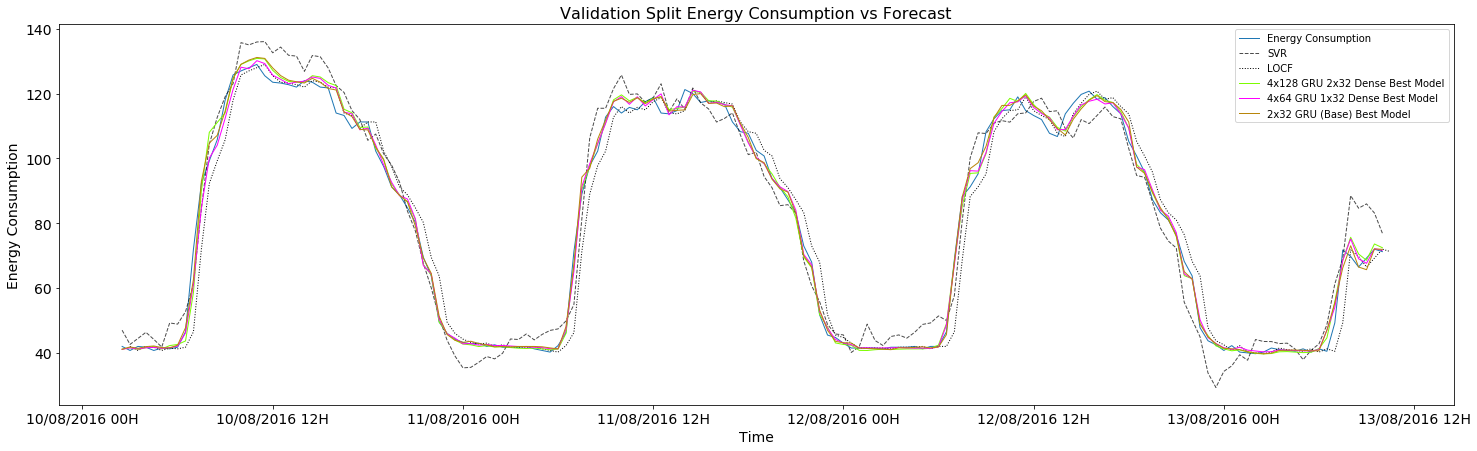

In [28]:
import matplotlib.dates as mdates

plt.figure(figsize=(25, 7))
plt.plot(mrb_train_df.iloc[20390:20550, mrb_train_df.columns.get_loc('PWM_30min_avg')], label='Energy Consumption')
plt.plot(mrb_train_df.index[20390:20550], mrb_val_preds_withnan[390:550].flatten(), color='black', label='SVR', alpha=.7, linestyle='--')
plt.plot(mrb_train_df.index[20391:20551], mrb_train_df.iloc[20390:20550, mrb_train_df.columns.get_loc('PWM_30min_avg')].values, color='black', label='LOCF', linestyle=':')  ## locf is data with lag -1
plt.plot(mrb_train_df.index[20390:20550], mrb_val_preds128_withnan[390:550].flatten(), label='4x128 GRU 2x32 Dense Best Model', color='lawngreen')
plt.plot(mrb_train_df.index[20390:20550], mrb_val_preds64_withnan[390:550].flatten(), label='4x64 GRU 1x32 Dense Best Model', color='magenta')
plt.plot(mrb_train_df.index[20390:20550], mrb_val_preds32_withnan[390:550].flatten(), label='2x32 GRU (Base) Best Model', color='darkgoldenrod')
plt.xlabel('Time')
plt.ylabel('Energy Consumption')
plt.title('Validation Split Energy Consumption vs Forecast')
plt.legend()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d/%m/%Y %HH'))
plt.gca().xaxis.set_major_locator(mdates.HourLocator(byhour=range(0, 24, 12)))

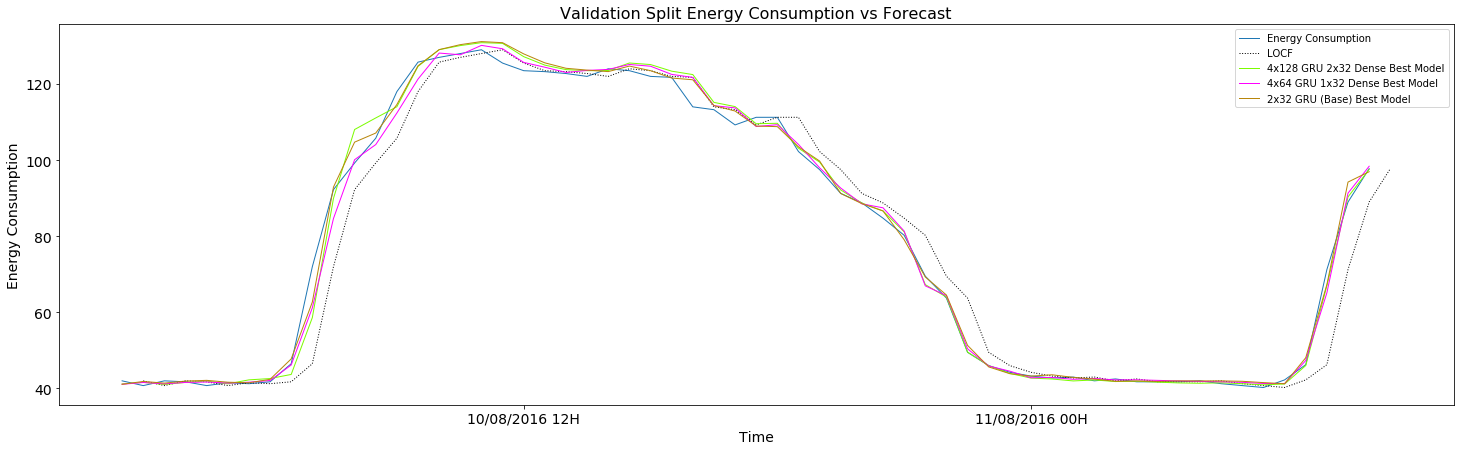

In [27]:
plt.figure(figsize=(25, 7))
plt.plot(mrb_train_df.iloc[20390:20450, mrb_train_df.columns.get_loc('PWM_30min_avg')], label='Energy Consumption')
# plt.plot(mrb_train_df.index[20390:20450], mrb_val_preds_withnan[390:450].flatten(), color='black', label='svr', alpha=.7, linestyle='--')
plt.plot(mrb_train_df.index[20391:20451], mrb_train_df.iloc[20390:20450, mrb_train_df.columns.get_loc('PWM_30min_avg')].values, color='black', label='LOCF', linestyle=':')  ## locf is data with lag -1
plt.plot(mrb_train_df.index[20390:20450], mrb_val_preds128_withnan[390:450].flatten(), label='4x128 GRU 2x32 Dense Best Model', color='lawngreen')
plt.plot(mrb_train_df.index[20390:20450], mrb_val_preds64_withnan[390:450].flatten(), label='4x64 GRU 1x32 Dense Best Model', color='magenta')
plt.plot(mrb_train_df.index[20390:20450], mrb_val_preds32_withnan[390:450].flatten(), label='2x32 GRU (Base) Best Model', color='darkgoldenrod')
plt.xlabel('Time')
plt.ylabel('Energy Consumption')
plt.title('Validation Split Energy Consumption vs Forecast')
plt.legend()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d/%m/%Y %HH'))
plt.gca().xaxis.set_major_locator(mdates.HourLocator(byhour=range(0, 24, 12)))

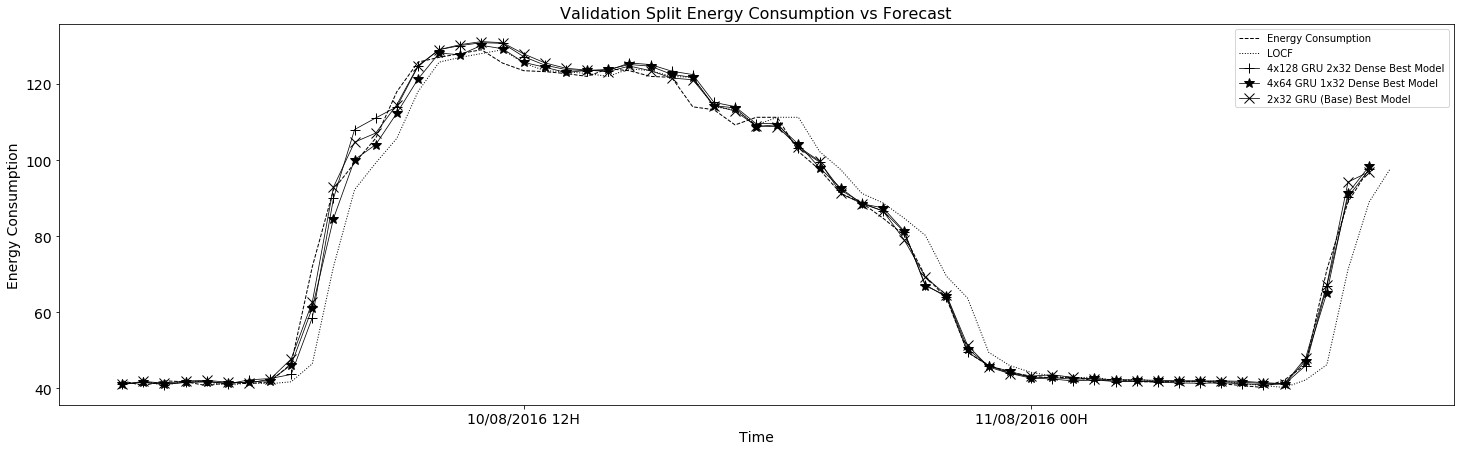

In [26]:
plt.figure(figsize=(25, 7))
plt.plot(mrb_train_df.iloc[20390:20450, mrb_train_df.columns.get_loc('PWM_30min_avg')], label='Energy Consumption', color='black', linestyle='--')
# plt.plot(mrb_train_df.index[20390:20450], mrb_val_preds_withnan[390:450].flatten(), color='black', label='svr', alpha=.7, linestyle='--')
plt.plot(mrb_train_df.index[20391:20451], mrb_train_df.iloc[20390:20450, mrb_train_df.columns.get_loc('PWM_30min_avg')].values, color='black', label='LOCF', linestyle=':')  ## locf is data with lag -1
plt.plot(mrb_train_df.index[20390:20450], mrb_val_preds128_withnan[390:450].flatten(), 'k+-', label='4x128 GRU 2x32 Dense Best Model', linewidth=.75)
plt.plot(mrb_train_df.index[20390:20450], mrb_val_preds64_withnan[390:450].flatten(), 'k*-', label='4x64 GRU 1x32 Dense Best Model', linewidth=.75)
plt.plot(mrb_train_df.index[20390:20450], mrb_val_preds32_withnan[390:450].flatten(), 'kx-', label='2x32 GRU (Base) Best Model', linewidth=.75)
plt.xlabel('Time')
plt.ylabel('Energy Consumption')
plt.title('Validation Split Energy Consumption vs Forecast')
plt.legend()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d/%m/%Y %HH'))
plt.gca().xaxis.set_major_locator(mdates.HourLocator(byhour=range(0, 24, 12)))

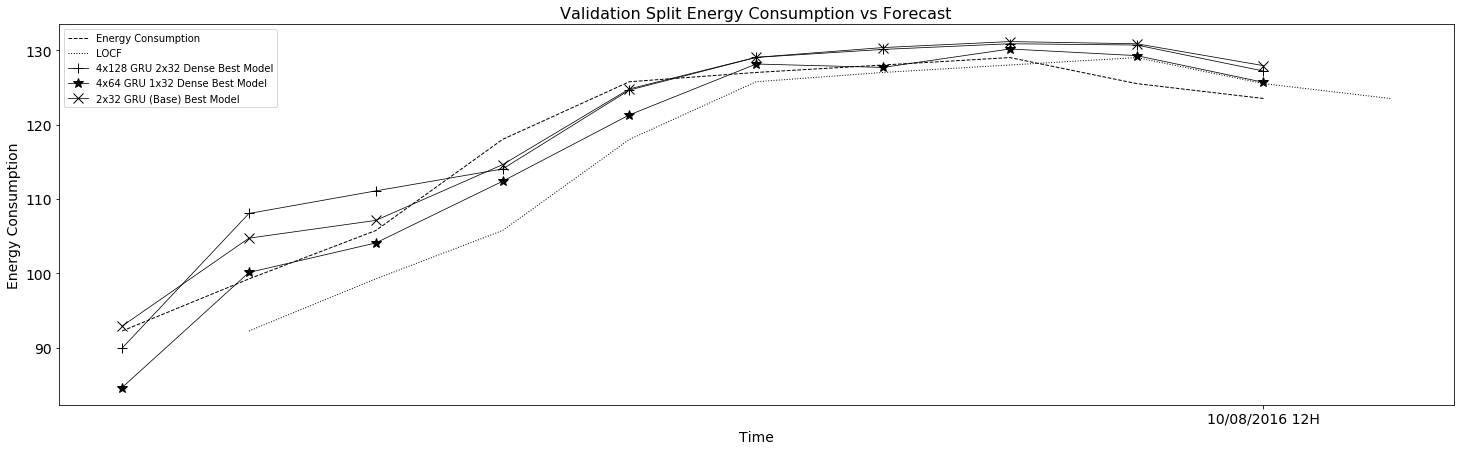

In [25]:
plt.figure(figsize=(25, 7))
plt.plot(mrb_train_df.iloc[20400:20410, mrb_train_df.columns.get_loc('PWM_30min_avg')], label='Energy Consumption', color='black', linestyle='--')
# plt.plot(mrb_train_df.index[20390:20450], mrb_val_preds_withnan[390:450].flatten(), color='black', label='svr', alpha=.7, linestyle='--')
plt.plot(mrb_train_df.index[20401:20411], mrb_train_df.iloc[20400:20410, mrb_train_df.columns.get_loc('PWM_30min_avg')].values, color='black', label='LOCF', linestyle=':')  ## locf is data with lag -1
plt.plot(mrb_train_df.index[20400:20410], mrb_val_preds128_withnan[400:410].flatten(), 'k+-', label='4x128 GRU 2x32 Dense Best Model', linewidth=.75)
plt.plot(mrb_train_df.index[20400:20410], mrb_val_preds64_withnan[400:410].flatten(), 'k*-', label='4x64 GRU 1x32 Dense Best Model', linewidth=.75)
plt.plot(mrb_train_df.index[20400:20410], mrb_val_preds32_withnan[400:410].flatten(), 'kx-', label='2x32 GRU (Base) Best Model', linewidth=.75)
plt.xlabel('Time')
plt.ylabel('Energy Consumption')
plt.title('Validation Split Energy Consumption vs Forecast')
plt.legend()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d/%m/%Y %HH'))
plt.gca().xaxis.set_major_locator(mdates.HourLocator(byhour=range(0, 24, 12)))